In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

# Dimensionality reduction
## Overview

* there is a wide variety of dimensionality reduction and manifold learning methods
* common theme: assume that data in high-dimensional space actually approximately lives on low-dimensional sub-manifold
* try and find embedding of this sub-manifold into low-dimensional space
* motivation:
  * interpretibility
  * robustness for subsequent processing / machine learning

Different methods can roughly be characterized by the following criteria:
* different types of losses / try to preserve different aspects of original data
  * preserve pairwise distance of points, Euclidean or more general distances
  * preserve neighourhood structure: neighbours in original space should remain neighbours in embedding
  * lwo-dimensional embedding is approximately invertible
  * low-dimensional embedding should separate classes well (supervised)
* different embedding functions (linear, linear+kernel trick, ANNs, ...)

Typical questions / tasks for visualization:
  * where do samples lie in low dim embedding? are samples that are close in embedding similar? do we observe meaningful clusters?
  * what do low-dim coordinates mean? is there an inverse map? how faithful is encoding+decoding?
* other important questions:
  * what is a good metric for samples that the embedding should seek to preserve?
  * what is the intrinsic dimension of our dataset? (at which length scales?)

# PCA
PCA is essentially the simplest method, easy to understand, transparent, serves as a useful prototype to understand more complex methods, usually the first thing one should try.

In [2]:
# for simplicity we use our own basic implementation
# dataMat is assumed to be matrix of shape (nSamples,dimSample)
def PCA(dataMat,keep=None,centered=False):
    nSamples,dim=dataMat.shape
    # centerted True, then data is already centered
    if not centered:
        mean=np.mean(dataMat,axis=0)
        dataMat=dataMat.copy()
        dataMat=dataMat-mean
    if dim<nSamples:
        if keep is None:
            keep=dim
        A=dataMat.transpose().dot(dataMat)/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]
    else:
        if keep is None:
            keep=nSamples
        A=dataMat.dot(dataMat.transpose())/nSamples
        eigData=np.linalg.eigh(A)
        eigval=(eigData[0][-keep::])[::-1]
        eigvec=((eigData[1][:,-keep::]).transpose())[::-1]

        eigvec=np.einsum(eigvec,[0,1],dataMat,[1,2],[0,2])
        # renormalize
        normList=np.linalg.norm(eigvec,axis=1)
        eigvec=np.einsum(eigvec,[0,1],1/normList,[0],[0,1])
    if not centered:
        return mean,eigval,eigvec
    else:
        return eigval,eigvec

## Basic example and illustration

In [3]:
nPts=200
dim=3
data=np.random.normal(size=(nPts,dim))
# scale axes differently
scales=np.array([1.,0.5,0.2])
data*=scales
# change directions of axes
# each row of A contains a direction into which the corresponding dimension of data should be pointed
A=np.array([[1.,1.,1.],[0.,1.,-1.],[1.,-0.5,-0.5]])
# normalize rows of A to unit length
norms=np.linalg.norm(A,axis=1)
A/=norms.reshape((-1,1))
data=data@A

In [4]:
data.shape

(200, 3)

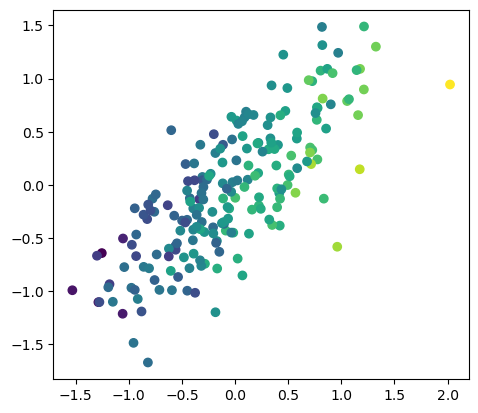

In [5]:
# basic 2d plot with third dimension as color
# we see: color is definitely strongly correlated with position
# so the positions do not tell the full story of the data
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(aspect=1.)
plt.scatter(data[:,0],data[:,1],c=data[:,2])
plt.show()

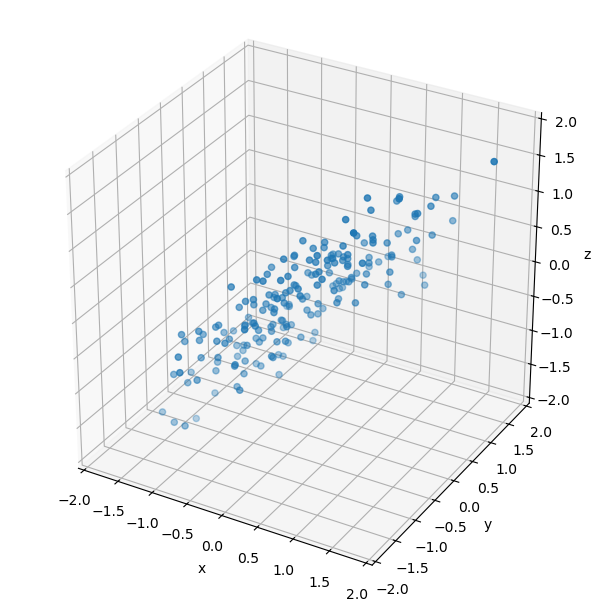

In [6]:
# visualize data as 3d point cloud
# gives full representation of data,
# but we may not always be so lucky that data is only 3d.
# so we need to think about reduction methods
%matplotlib widget
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
# aspect ratio
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])
ax.set_box_aspect((1.,1.,1.))

ax.scatter(data[:,0],data[:,1],data[:,2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

In [8]:
plt.close()
%matplotlib inline

In [9]:
# now apply PCA
mean,eigval,eigvec=PCA(data)

In [10]:
# compare PCA eigenvalues with the prescribed scales

# eigenvalues: correspond to variance along the principal directions
print(f"sqrt(eigenvalues): {np.sqrt(eigval)}\tscales: {scales}")

sqrt(eigenvalues): [0.98607726 0.46779193 0.19514786]	scales: [1.  0.5 0.2]


In [11]:
# compare PCA eigenvectors to rows of A
print(f"eigvec:\n{eigvec}")
print(f"A:\n{A}")

eigvec:
[[-0.61864718 -0.51773662 -0.59095216]
 [-0.01591988 -0.7437493   0.66826906]
 [-0.78550762  0.42283066  0.4518761 ]]
A:
[[ 0.57735027  0.57735027  0.57735027]
 [ 0.          0.70710678 -0.70710678]
 [ 0.81649658 -0.40824829 -0.40824829]]


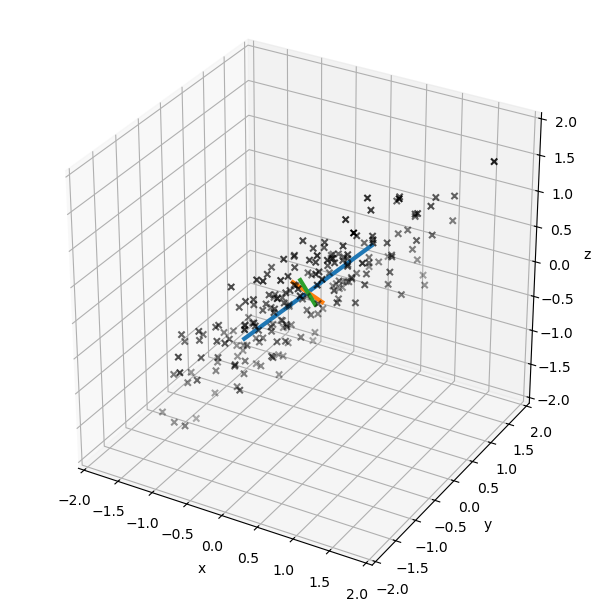

In [12]:
# add eigenvectors with scale to plot
%matplotlib widget
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
# aspect ratio
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])
ax.set_box_aspect((1.,1.,1.))
# this step is required such that eigenvectors actually appear perpendicular to each other

ax.scatter(data[:,0],data[:,1],data[:,2],marker="x",color="k")
for i,(val,vec) in enumerate(zip(eigval,eigvec)):
    # let x be the (unit) eigenvector, scaled by sqrt of eigenvalue (=std deviation)
    x=vec*(val**0.5)
    # add line from -x to x into plot
    ax.plot([-x[0],x[0]],[-x[1],x[1]],[-x[2],x[2]],color=colors[i],lw=3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.tight_layout()
plt.show()

In [13]:
plt.close()
%matplotlib inline

In [14]:
# projecting the points onto the eigenbasis
# (position of each point along the three colored lines)

#coef=(data-mean)@eigvec.T
# alternative, explicit formula with einsum
coef=np.einsum(eigvec,[0,1],data-mean,[2,1],[2,0])
print(coef.shape)

(200, 3)


In [15]:
# compare covariance matrix of naive data, and of PCA coefficients
# by construction: the latter is diagonal
covBefore=np.cov(data.transpose(),bias=True)
covAfter=np.cov(coef.transpose(),bias=True)
print("cov of data:")
print(covBefore)
print("cov of transformed data:")
print(covAfter)
print("recall eigenvalues:")
print(eigval)
print("recall (squared) scales:")
print(scales**2)

cov of data:
[[0.39569471 0.30138196 0.3396361 ]
 [0.30138196 0.38849607 0.19601015]
 [0.3396361  0.19601015 0.44506957]]
cov of transformed data:
[[ 9.72348372e-01 -1.29702426e-17  5.67683429e-17]
 [-1.29702426e-17  2.18829291e-01 -2.96460691e-16]
 [ 5.67683429e-17 -2.96460691e-16  3.80826891e-02]]
recall eigenvalues:
[0.97234837 0.21882929 0.03808269]
recall (squared) scales:
[1.   0.25 0.04]


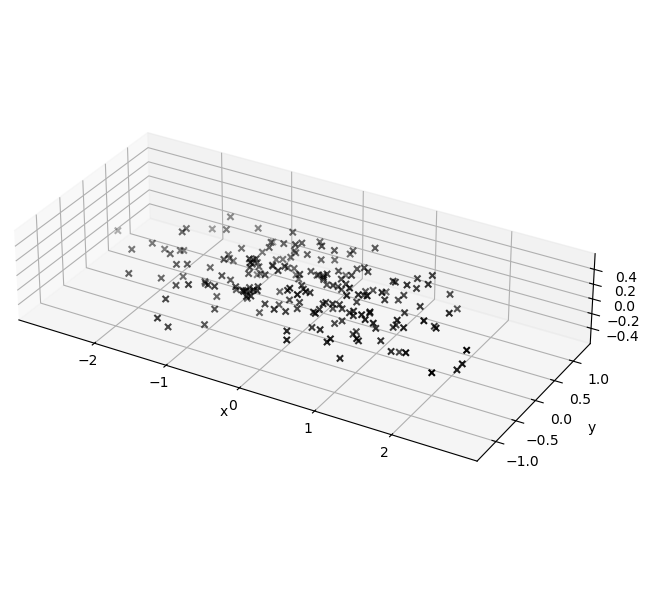

In [16]:
# plot transformed coordinates
%matplotlib inline
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
# set lim of each axis to -3 to +3 sigma of the given axis
ax.set_xlim([-3*eigval[0]**0.5,3*eigval[0]**0.5])
ax.set_ylim([-3*eigval[1]**0.5,3*eigval[1]**0.5])
ax.set_zlim([-3*eigval[2]**0.5,3*eigval[2]**0.5])
# set uniform aspect ratio = plot will look like cube
#ax.set_box_aspect((1.,1.,1.))
# aspect according to standard deviation
ax.set_box_aspect(eigval**0.5)

ax.scatter(coef[:,0],coef[:,1],coef[:,2],marker="x",color="k")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.tight_layout()
plt.show()

ValueError: 'berlin' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

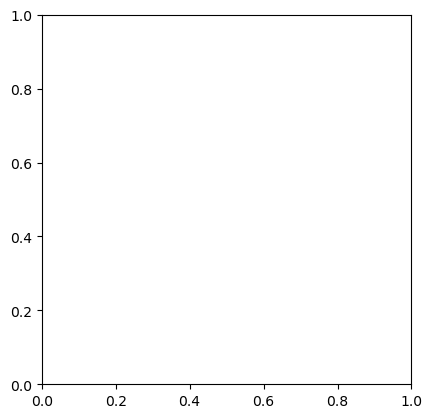

In [17]:
# now a 2d embedding is more meaningful
%matplotlib inline
fig=plt.figure()
fig.add_subplot(aspect=1.)
plt.scatter(coef[:,0],coef[:,1],marker="x",c=coef[:,2],cmap="berlin")
plt.show()
# this is the "best" 2d representation of the original point cloud
# in the sense that it is the 2d projection with the least loss of variance
# note: now color is uncorrelated with position

## Examples to illustrate key properties

### PCA is susceptible to outliers

In [19]:
nPts=200
dim=2
data=np.random.normal(size=(nPts,dim))
# scale axes differently
scales=np.array([1.,0.1])
data*=scales

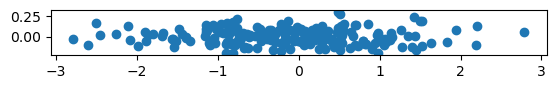

In [20]:
fig=plt.figure()
ax=fig.add_subplot(aspect=1.)
plt.scatter(data[:,0],data[:,1])
plt.show()

In [21]:
PCA(data)

(array([-0.15741153,  0.00263857]),
 array([0.96987877, 0.00940872]),
 array([[-0.99999161,  0.00409634],
        [-0.00409634, -0.99999161]]))

In [22]:
dataCorrupted=data.copy()
dataCorrupted[0,:]=np.array([0,10])

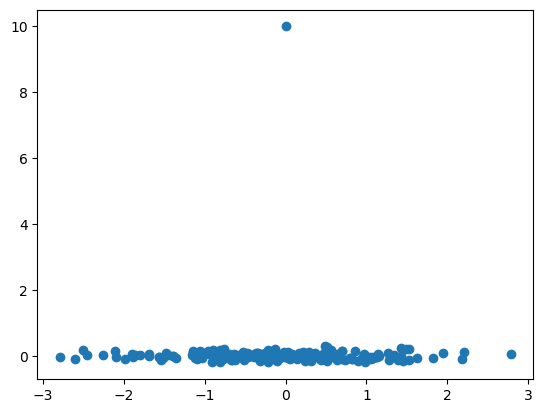

In [23]:
plt.scatter(dataCorrupted[:,0],dataCorrupted[:,1])
plt.figaspect(1.)
plt.show()

In [24]:
PCA(dataCorrupted)

(array([-0.15292744,  0.05307067]),
 array([0.96725761, 0.50655318]),
 array([[-0.99997311, -0.00733402],
        [ 0.00733402, -0.99997311]]))

### Visualization of the spectrum

#### Estimation of intrinsic dimension of dataset

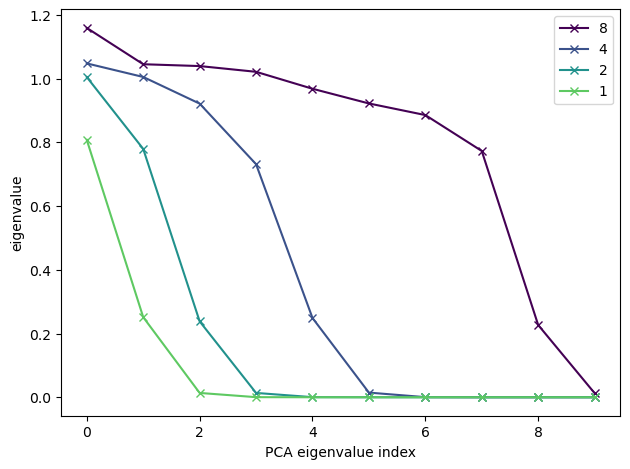

In [25]:
nPts=1000
dim=10
data=np.random.normal(size=(nPts,dim))
# exponential decay of scales in dimensions
scalelist=[8,4,2,1]
eigvalList=[]
f = lambda x : 0.5*(1-np.tanh(x))
for i,scale in enumerate(scalelist):
    scales=f((np.arange(dim)-scale))
    dataScaled=data*scales
    mean,eigval,eigvec=PCA(dataScaled)
    plt.plot(eigval,label=scale,c=cm.viridis(i/len(scalelist)),marker="x")
    eigvalList.append(eigval)
plt.legend()
plt.xlabel("PCA eigenvalue index")
plt.ylabel("eigenvalue")
plt.tight_layout()
plt.show()

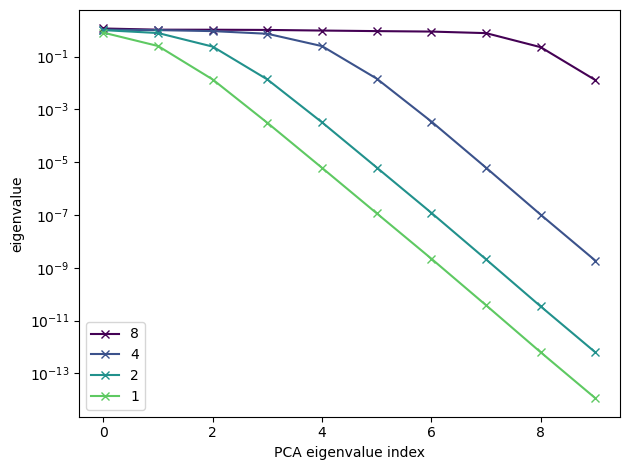

In [26]:
for i,scale in enumerate(scalelist):
    eigval=eigvalList[i]
    plt.plot(eigval,label=scale,c=cm.viridis(i/len(scalelist)),marker="x")
    eigvalList.append(eigval)
plt.legend()
plt.xlabel("PCA eigenvalue index")
plt.ylabel("eigenvalue")
plt.yscale("log")
plt.tight_layout()
plt.show()
# note: the eigenvalues are often displayed in log scale
# to learn about the behaviour of the "tail"

#### Typical visualization: cumulative fraction of variance

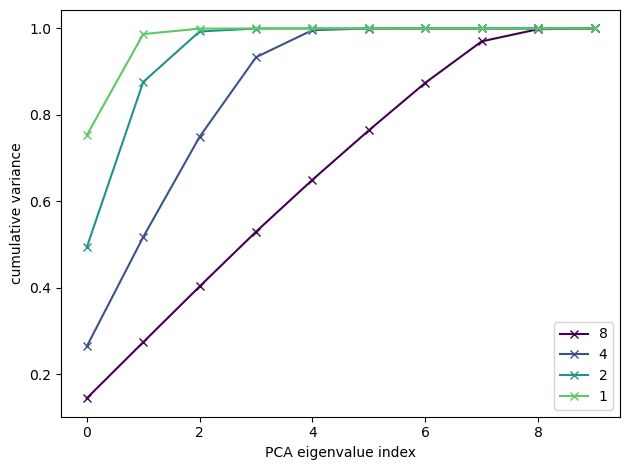

In [27]:
for i,scale in enumerate(scalelist):
    eigval=eigvalList[i]
    cumsum=np.cumsum(eigval)
    cumsum/=cumsum[-1]
    plt.plot(cumsum,label=scale,c=cm.viridis(i/len(scalelist)),marker="x")
plt.legend()
plt.xlabel("PCA eigenvalue index")
plt.ylabel("cumulative variance")
plt.tight_layout()
plt.show()

### Limitation of linearity
* PCA does not find best low-dimensional embeddings when data lives on non-linear submanifold
* in the following example, the "spiral dataset" arguably has an intrinsic dimension of 1, but PCA will (of course) find 3 substantial non-zero eigenvalues

In [28]:
nPts=1000
dim=3
eps=0.01 # noise level
# data living on a straight line (with a little noise)
data1=np.zeros((nPts,dim))
data1[:,0]=np.linspace(-1,1,num=nPts)
data1+=eps*np.random.normal(size=(nPts,dim))
# data living on a spiral
data2=np.zeros((nPts,dim))
data2[:,2]=np.linspace(-1,1,num=nPts)
phi=np.linspace(0,2*np.pi,num=nPts)
data2[:,0]=np.cos(4*phi)
data2[:,1]=np.sin(4*phi)
data2+=eps*np.random.normal(size=(nPts,dim))

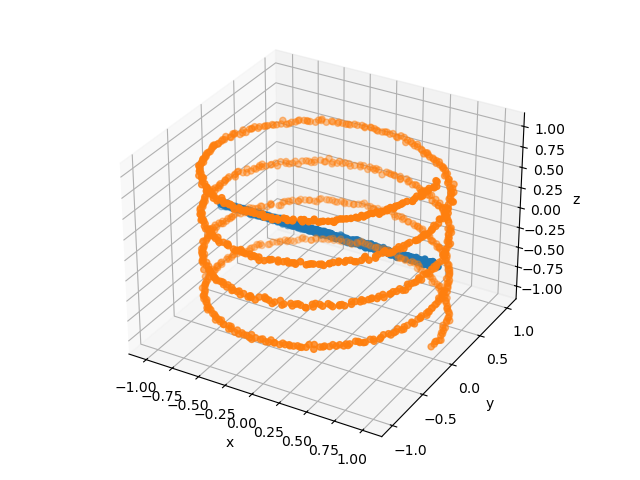

In [29]:
# add eigenvectors with scale to plot
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(data1[:,0],data1[:,1],data1[:,2])
ax.scatter(data2[:,0],data2[:,1],data2[:,2])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.tight_layout()
plt.show()

In [30]:
plt.close()
%matplotlib inline

In [31]:
pcadat1=PCA(data1)
pcadat1

(array([ 3.64888991e-04, -2.86112128e-05, -4.57714367e-04]),
 array([3.33797329e-01, 9.78257034e-05, 8.80898526e-05]),
 array([[-9.99999799e-01, -1.70784443e-04,  6.11022785e-04],
        [-3.90630201e-04,  9.24630261e-01, -3.80865762e-01],
        [-4.99924210e-04, -3.80865924e-01, -9.24630141e-01]]))

In [32]:
pcadat2=PCA(data2)
pcadat2

(array([ 1.52922103e-03, -3.70595077e-05, -3.99076065e-05]),
 array([0.53186547, 0.50078719, 0.30178457]),
 array([[ 1.28068974e-04,  9.27811340e-01, -3.73049731e-01],
        [ 9.99999880e-01,  5.76124101e-05,  4.86590368e-04],
        [ 4.72956355e-04, -3.73049748e-01, -9.27811221e-01]]))

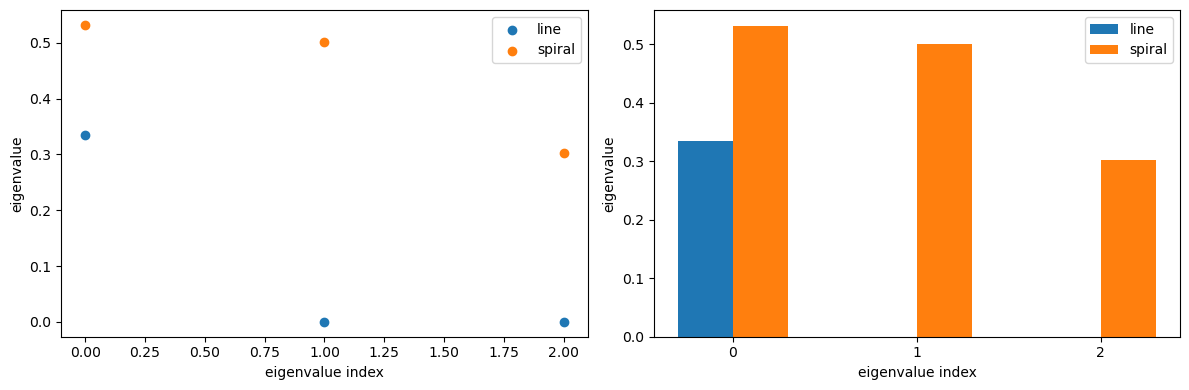

In [33]:
fig=plt.figure(figsize=(12,4))

ax=fig.add_subplot(1,2,1)
plt.scatter(np.arange(3),pcadat1[1],label="line",marker="o")
plt.scatter(np.arange(3),pcadat2[1],label="spiral",marker="o")
plt.xlabel("eigenvalue index")
plt.ylabel("eigenvalue")
plt.legend()

ax=fig.add_subplot(1,2,2)
plt.bar(np.arange(3),pcadat1[1],width=0.3,label="line")
plt.bar(np.arange(3)+0.3,pcadat2[1],width=0.3,label="spiral")
plt.xlabel("eigenvalue index")
plt.xticks(np.arange(3)+0.15,np.arange(3))
plt.ylabel("eigenvalue")
plt.legend()

plt.tight_layout()
plt.show()

### Do not forget to center data!

In [34]:
nPts=100
dim=2
data=np.random.normal(size=(nPts,dim))*np.array([0.1,1])+np.array([2.,0.])
# squeeze in x-direction and shift in x-direction

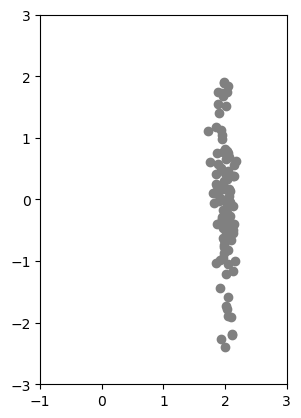

In [35]:
fig=plt.figure()
ax=fig.add_subplot(aspect=1.)

plt.scatter(data[:,0],data[:,1],c="#808080")
plt.xlim([-1,3])
plt.ylim([-3,3])
plt.show()

In [36]:
# now claim that matrix is already centered! even though it is not
eigval,eigvec=PCA(data,centered=True)

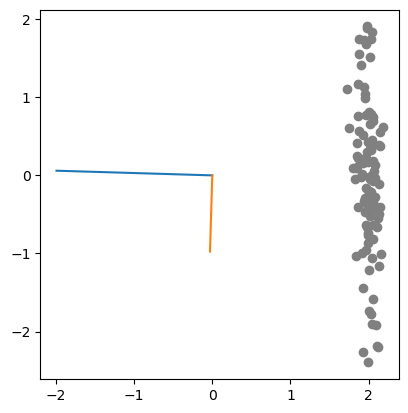

In [37]:
fig=plt.figure()
ax=fig.add_subplot(aspect=1.)
plt.scatter(data[:,0],data[:,1],c="#808080")

for i in range(dim):
    val=eigval[i]**0.5
    vec=eigvec[i]
    plt.plot([0,val*vec[0]],[0,val*vec[1]])

#plt.xlim([-1,2])
#plt.ylim([-3,3])
plt.show()

### PCA is unsupervised, may miss discriminating direction
* sometimes the "cause" for a class label that one is looking for
  is relatively subtle compared to other variance in the data.
* in these cases, dimensionality reduction may conceal the proper relationship 

In [38]:
nPts=100
dim=2
scales=np.array([1.,0.1])
offset=np.array([0,0.2])
Y=np.zeros((2*nPts,),dtype=int)
Y[:nPts]=-1
Y[nPts:]=+1


X=np.random.normal(size=(2*nPts,dim))*scales+offset.reshape((1,-1))*Y.reshape((-1,1))

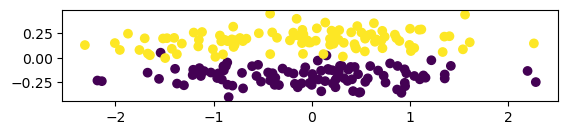

In [39]:
fig=plt.figure()
ax=fig.add_subplot(aspect=1.)
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [40]:
# here the direction of most variance is along horizontal axis,
# but this is completely useless for discriminating between two classes

# Example for Image Analysis: Mini-MNIST

In [41]:
# this is a very simple standard example for image classification
# we try a few variants:
# * 8x8 and 28x28 resolution;
# * all classes and 2 classes
# here even PCA works a little bit
# in general Euclidean distance is NOT a meaningful metric on images; this only works because the image resolution is so low

## Prepare data

### 8x8 version

In [42]:
import sklearn.datasets

ModuleNotFoundError: No module named 'sklearn'

In [69]:
digits = sklearn.datasets.load_digits()
digits.data.shape

data=digits.data
labels=digits.target
imgdim=(8,8)
del digits

### 28x28 version

In [98]:
# for comparison: the 28x28 pixel version
datapre=np.load("data/mnist.npz")
data=datapre["data"]
labels=datapre["labels"]
imgdim=(28,28)

In [99]:
data.shape

(70000, 784)

In [100]:
# some subsampling
sel=np.random.choice(len(data),10000,replace=False)
data=data[sel]
labels=labels[sel]

In [101]:
data.shape

(10000, 784)

### Filter classes

In [102]:
keepClasses=[1,7]
keepIndices=np.isin(labels,keepClasses)

data=data[keepIndices]
labels=labels[keepIndices]

In [103]:
# check dimension
data.shape

(2216, 784)

### Visualize a few exemplary samples

In [104]:
%matplotlib inline

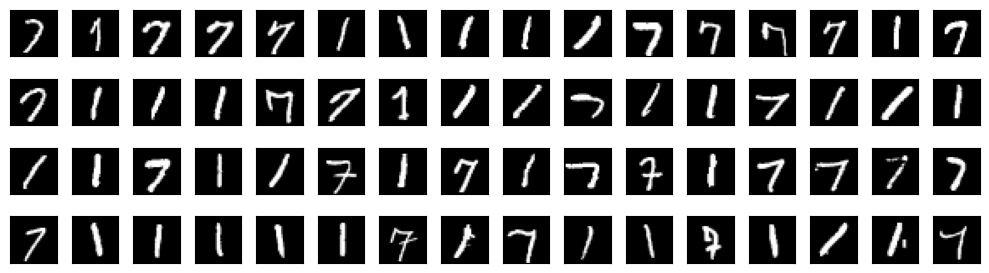

In [105]:
fig=plt.figure(figsize=(10,3))
axs=fig.subplots(4,16).ravel()

selimgs=np.random.choice(len(data),size=len(axs),replace=False)
for ax,sel in zip(axs,selimgs):
    ax.imshow(data[sel].reshape(imgdim),cmap=cm.grey)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## PCA analysis

In [106]:
mean,eigval,eigvec=PCA(data)

In [107]:
dataCentered=data-mean

### Spectrum and cumulative variance

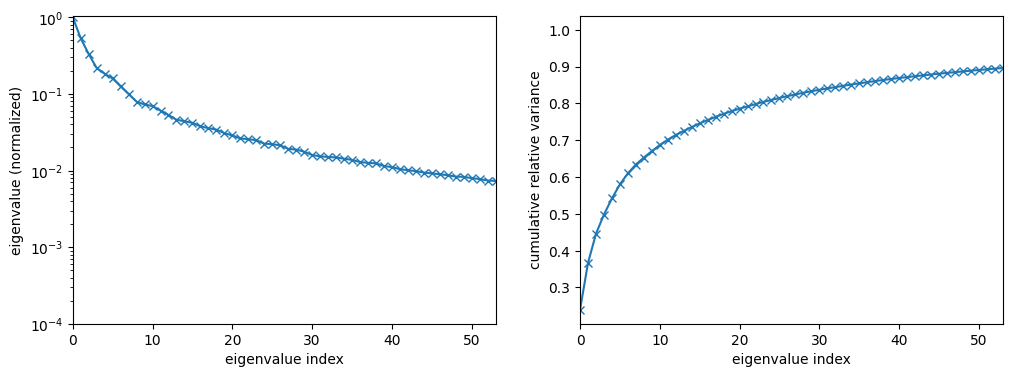

In [108]:
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,2)

ax=axs[0]
ax.plot(eigval/eigval[0],marker="x")
ax.set_yscale("log")
ax.set_xlim([0,53])
ax.set_ylim([1E-4,1.05])
ax.set_xlabel("eigenvalue index")
ax.set_ylabel("eigenvalue (normalized)")

ax=axs[1]
cumdat=np.cumsum(eigval)
cumdat/=cumdat[-1]
ax.plot(cumdat,marker="x")
#ax.set_yscale("log")
ax.set_xlim([0,53])
#ax.set_ylim([1E-4,1.05])
ax.set_xlabel("eigenvalue index")
ax.set_ylabel("cumulative relative variance")


plt.show()

### PCA embedding

In [109]:
# now we compute coordinates of samples along PCA components
# this is the same formula as in the 3d example above; now it feels more complicated, since we project "images"
coefs=dataCentered@eigvec[:5,:].T
print(coefs.shape)

(2216, 5)


In [110]:
# * we can then show the "projected coordinates" as a scatter plot
# * usually the top two, but also other combinations might be worth a try
# * for labelled data it is convenient to encode the class by color
# * in this way we can check if the low-dimensional embedding captured the relevant aspects of the data
#   and explore the internal structure and relative position of individual samples

In [1]:
# note that here we discretize the color map via the boundaries argument
# this makes it easier to distinguish the classes
# note that we use a sequential colormap for our ordinal datatype
def labelplot(pos,labels,ax=None):
    if ax is None:
        axobj=plt.gca()
    else:
        axobj=ax
    pltobj=axobj.scatter(pos[:,0],pos[:,1],c=labels,cmap="Spectral",marker="x",vmin=0,vmax=9)
    plt.colorbar(pltobj,boundaries=np.arange(11)-0.5,ax=axobj).set_ticks(np.arange(10))
    if ax is None:
        plt.show()
    return pltobj

In [112]:
%matplotlib inline

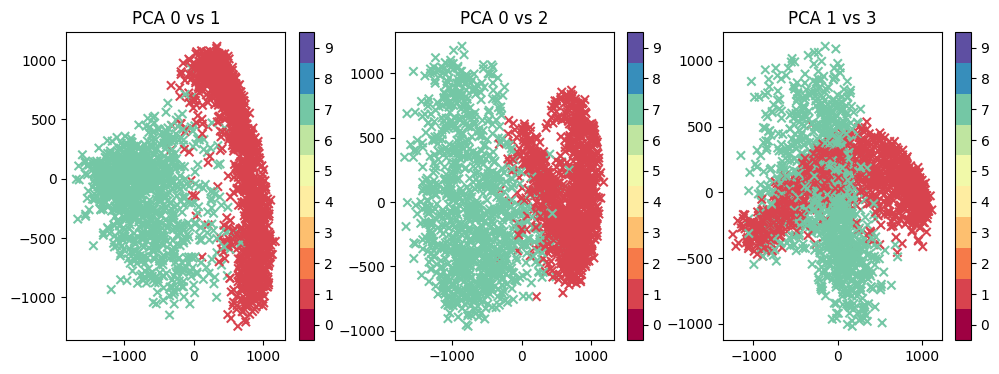

In [113]:
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,3)

ax=axs[0]
ax.set_title("PCA 0 vs 1")
labelplot(coefs[:,:2],labels,ax)

ax=axs[1]
ax.set_title("PCA 0 vs 2")
labelplot(coefs[:,[0,2]],labels,ax)

ax=axs[2]
ax.set_title("PCA 1 vs 3")
labelplot(coefs[:,[1,3]],labels,ax)

plt.show()

### Visualize the PCA eigenvectors ("modes")

In [114]:
# we want to visualize the eigenvectors onto which we have projected the data
# but now each eigenvector is very high dimensional;
# but: it can be interpreted as image! so we can visualize them as images
# common strategy: start from "mean image" and show variations obtained by adding scaled eigenvectors
# typically: one standard deviation along each direction (standard deviation is sqrt of corresponding eigenvalue)

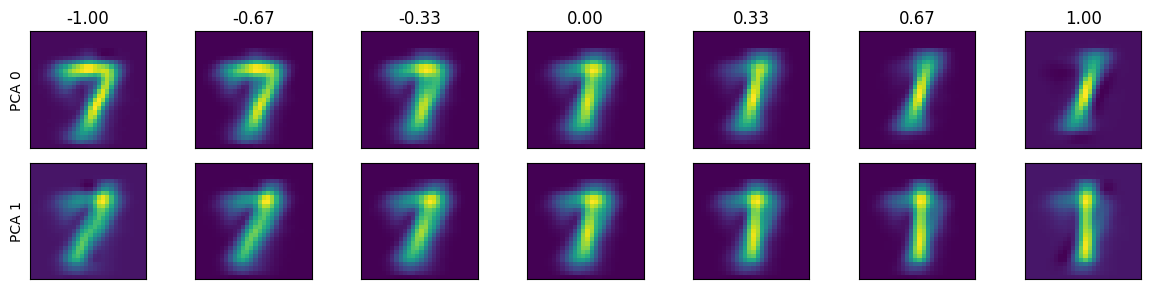

In [115]:
# some values in interval [-1,1]: used to move from -1 to +1 standard deviation along a given axis
vals=np.linspace(-1,1,num=7)
# figure logistics
fig=plt.figure(figsize=(12,3))
axs=fig.subplots(2,len(vals))
# now go over first two eigenvectors
for i,(axsub,dimId) in enumerate(zip(axs,[0,1])):
    # generate the reverse image:
    # * start with mean
    # * then for each value in vals, multiply by sqrt of corresponding eigenvalue and corresponding eigenvector
    # * here this is done with broadcasting for the whole vals array at once
    #   so data_reverse will have shape [length(vals),image dim]
    data_reverse=mean+(eigval[dimId]**0.5)*vals.reshape((-1,1))*eigvec[dimId].reshape((1,-1))

    # now plot all images for one eigenvector as small multiples in one row
    for ax,val,h in zip(axsub,vals,data_reverse):
        # note: we reshape flattened images to image dimensions for display
        ax.imshow(h.reshape(imgdim))
        if i==0:
            # in top row:
            # show the relative standard deviation for each column
            ax.set_title(f"{val:.2f}")
        ax.set_xticks([])
        ax.set_yticks([])
    # in first column set dimension index as caption
    axsub[0].set_ylabel(f"PCA {dimId}")
plt.tight_layout()
plt.show()

### Display samples on hover

NameError: name 'labelplot' is not defined

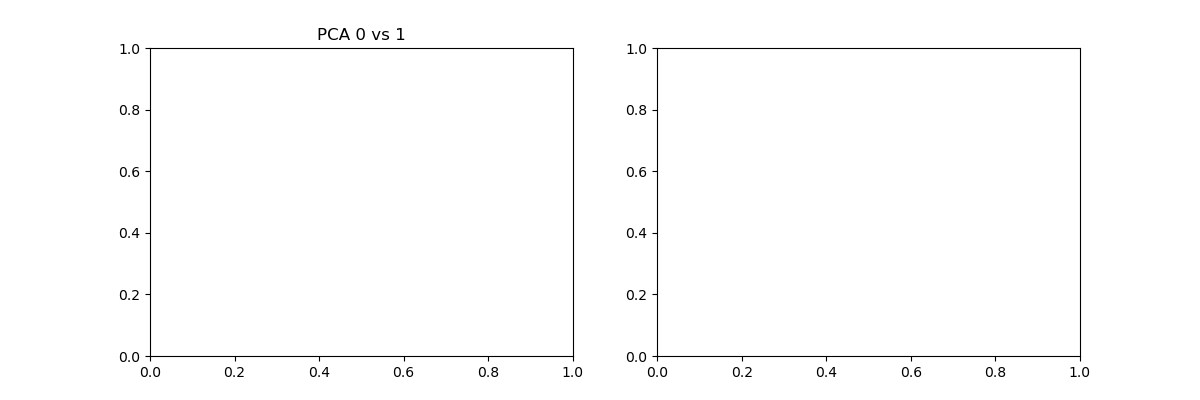

In [43]:
%matplotlib widget
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,2)

ax0=axs[0]
ax0.set_title("PCA 0 vs 1")
pltobj=labelplot(coefs[:,:2],labels,ax0)

ax1=axs[1]
vmax=np.max(data)
imobj=ax1.imshow(np.zeros(imgdim),vmin=0,vmax=vmax,cmap=cm.grey)

def onmouse(event):
    cont, details = pltobj.contains(event)
    if cont:
        #ind=details["ind"][0]
        ind=np.random.choice(details["ind"],size=1)[0]
        img=data[ind]
        imobj.set_data(img.reshape(imgdim))

cid = fig.canvas.mpl_connect('button_press_event', onmouse)
plt.show()

In [128]:
plt.close()
%matplotlib inline

### Inverse transformation

In [129]:
%matplotlib widget

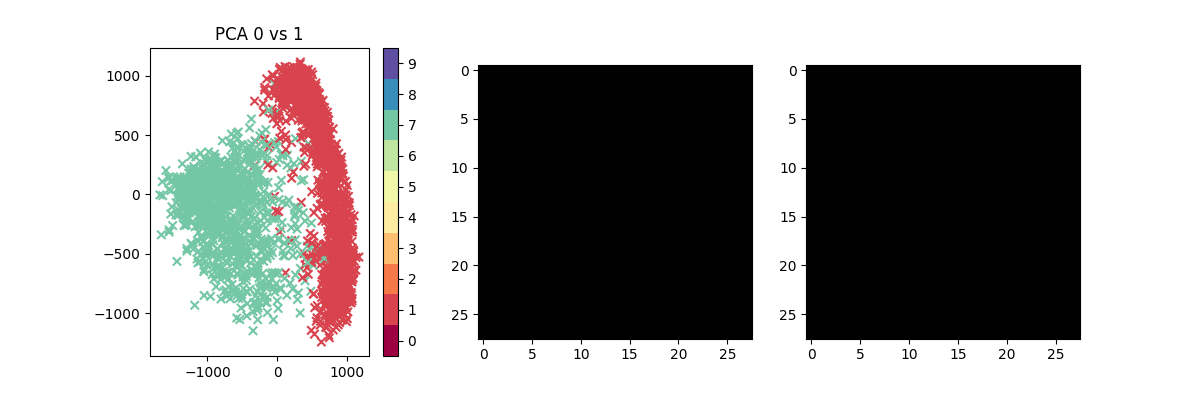

In [130]:
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,3)

ax0=axs[0]
ax0.set_title("PCA 0 vs 1")
pltobj=labelplot(coefs[:,:2],labels,ax0)

vmax=np.max(data)
ax1=axs[1]
imobj=ax1.imshow(np.zeros(imgdim),vmin=0,vmax=vmax,cmap=cm.grey)

ax2=axs[2]
imobj2=ax2.imshow(np.zeros(imgdim),vmin=0,vmax=vmax,cmap=cm.grey)

def onmouse(event):
    # projected image
    cont, details = ax0.contains(event)
    if cont:
        # reconstruct image corresponding to click position
        img=mean+eigvec[0]*event.xdata+eigvec[1]*event.ydata
        
        imobj2.set_data(img.reshape(imgdim))

    # clicked sample
    cont, details = pltobj.contains(event)
    if cont:
        ind=details["ind"][0]
        img=data[ind]
        imobj.set_data(img.reshape(imgdim))

cid = fig.canvas.mpl_connect('button_press_event', onmouse)
plt.show()

In [131]:
%matplotlib inline
plt.close()

## UMAP
There are many other dimensionality reduction and manifold learning methods, based on many different principles and ideas.

See for instance https://scikit-learn.org/stable/modules/manifold.html for a review of "classical" methods.

Another, relatively recent method is UMAP (Uniform Manifold Approximation and Projection for Dimension Reduction), see https://umap-learn.readthedocs.io/

It is more flexible but less transparent than PCA. It tends to work well on non-linear manifolds, but it uses local optimization that can get stuck in poor local minima.

In [132]:
import umap

In [137]:
%%time
reducer = umap.UMAP(n_components=2)
coefs=reducer.fit_transform(data);

/home/bernhard/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 17.4 s, sys: 145 ms, total: 17.5 s
Wall time: 5.89 s


In [138]:
%matplotlib widget

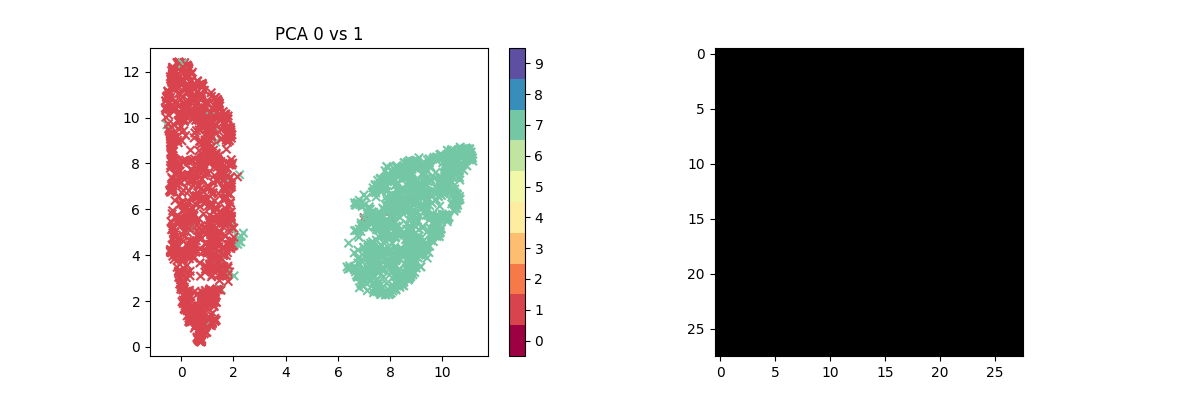

In [139]:
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,2)

ax0=axs[0]
ax0.set_title("PCA 0 vs 1")
pltobj=labelplot(coefs[:,:2],labels,ax0)

ax1=axs[1]
vmax=np.max(data)
imobj=ax1.imshow(np.zeros(imgdim),vmin=0,vmax=vmax,cmap=cm.grey)

def onmouse(event):
    cont, details = pltobj.contains(event)
    if cont:
        ind=details["ind"][0]
        img=data[ind]
        imobj.set_data(img.reshape(imgdim))

cid = fig.canvas.mpl_connect('button_press_event', onmouse)
plt.show()

In [140]:
plt.close()
%matplotlib inline

In [141]:
%matplotlib widget

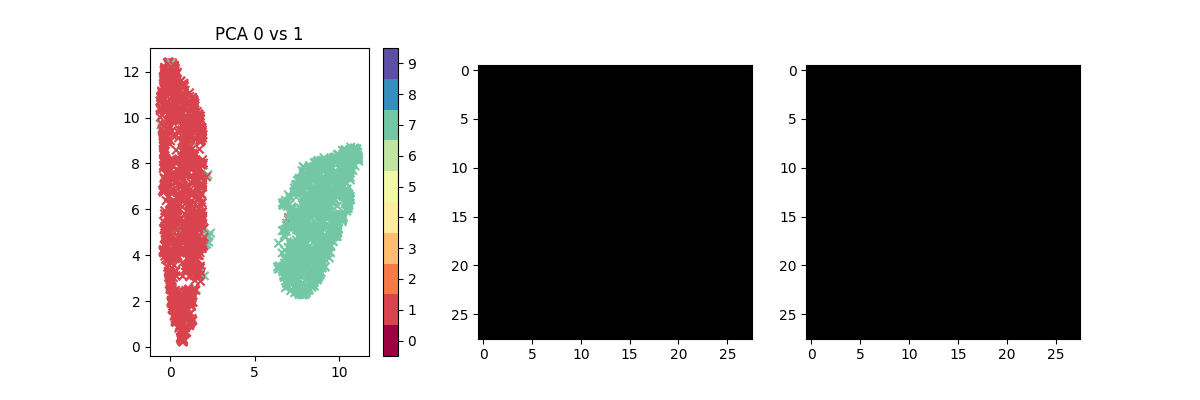

In [142]:
fig=plt.figure(figsize=(12,4))
axs=fig.subplots(1,3)

ax0=axs[0]
ax0.set_title("PCA 0 vs 1")
pltobj=labelplot(coefs[:,:2],labels,ax0)

vmax=np.max(data)
ax1=axs[1]
imobj=ax1.imshow(np.zeros(imgdim),vmin=0,vmax=vmax,cmap=cm.grey)

ax2=axs[2]
imobj2=ax2.imshow(np.zeros(imgdim),vmin=0,vmax=vmax,cmap=cm.grey)

def onmouse(event):
    # projected image
    cont, details = ax0.contains(event)
    if cont:
        # reconstruct image corresponding to click position
        img=reducer.inverse_transform(np.array([[event.xdata,event.ydata]]))
        
        imobj2.set_data(img.reshape(imgdim))

    # clicked sample
    cont, details = pltobj.contains(event)
    if cont:
        ind=details["ind"][0]
        img=data[ind]
        imobj.set_data(img.reshape(imgdim))

cid = fig.canvas.mpl_connect('button_press_event', onmouse)
plt.show()

# Example: Intrinsic dimension of dataset depends on length scale of analysis

In [143]:
# we build a zig zag line in 2d
# only neighbours along the line are considered, we will get a 1d embedding of a line
# if neighbours accross he "zigs" are considered, the embedding will look like a square

In [144]:
# aux functions to create zig zag line
# l: length of intermediate segments
# horizontal part
def f1(x,l):
    y=x%1
    offset=(x-y)*8*l
    if y<l:
        return 2*y+offset
    elif y<0.5-l:
        return 2*l+offset
    elif y<0.5+l:
        return 2*l+offset+2*(y-(0.5-l))
    elif y<1-l:
        return 6*l+offset
    else:
        return 6*l+offset+2*(y-(1-l))

# vertical part
def f2(x,l):
    y=x%1
    if y<l:
        return 0.0
    elif y<0.5-l:
        return (y-l)/(0.5-2*l)
    elif y<0.5+l:
        return 1.0
    elif y<1-l:
        return (1-l-y)/(0.5-2*l)
    else:
        return 0.0

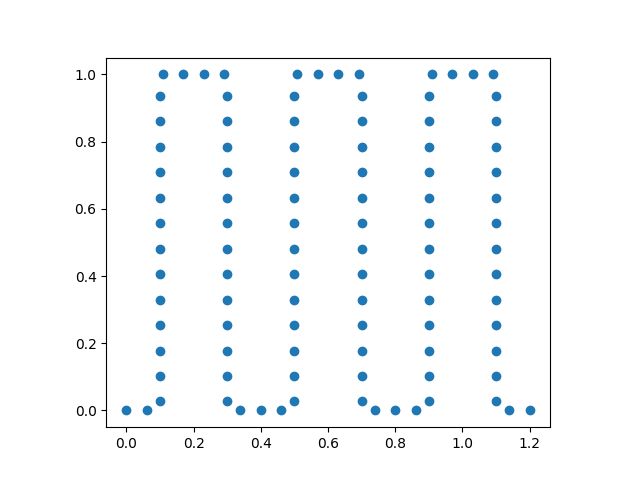

In [145]:
# simple example
x=np.linspace(0,3,num=100)
l=0.05
y1=np.array([f1(z,l) for z in x])
y2=np.array([f2(z,l) for z in x])
fig=plt.figure()
fig.add_subplot(aspect=1.)
plt.scatter(y1,y2)
plt.show()

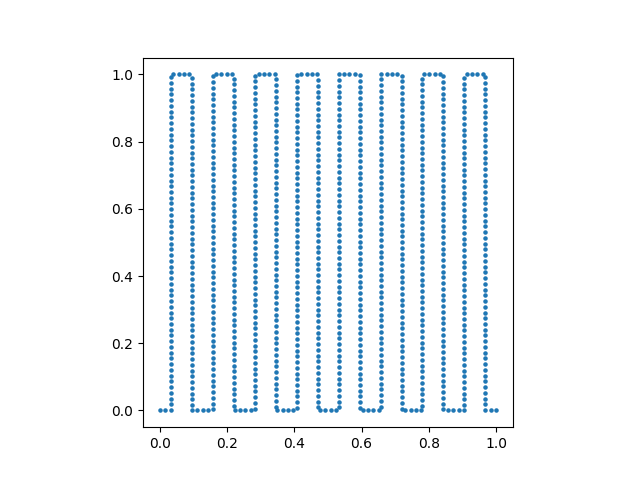

distance between two neighbouring points: 0.017083750417083432
distance between two neighbouring lines: 0.0625


In [146]:
# bigger example
nFlips=8
nPoints=1000
x=np.linspace(0,nFlips,num=nPoints)
l=1/8/nFlips
data=np.zeros((nPoints,2),dtype=np.double)
data[:,0]=np.array([f1(z,l) for z in x])
data[:,1]=np.array([f2(z,l) for z in x])

fig=plt.figure()
fig.add_subplot(aspect=1.)
plt.scatter(data[:,0],data[:,1],s=5)
plt.show()
#
print(f"distance between two neighbouring points: {np.median(np.linalg.norm(data[1:]-data[:-1],axis=1))}")
print(f"distance between two neighbouring lines: {1/2/nFlips}")

In [147]:
import umap

In [15]:
# in umap we can adjust the number of nearest neighbours to consider for the embedding
# here we choose two very different parameters to consider neighbourhood information at different scales

In [148]:
%%time
reducer1 = umap.UMAP(n_components=2,n_neighbors=8)
emb1=reducer1.fit_transform(data);
reducer2 = umap.UMAP(n_components=2,n_neighbors=100)
emb2=reducer2.fit_transform(data);

/home/bernhard/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/bernhard/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 18 s, sys: 2.18 ms, total: 18 s
Wall time: 4.07 s


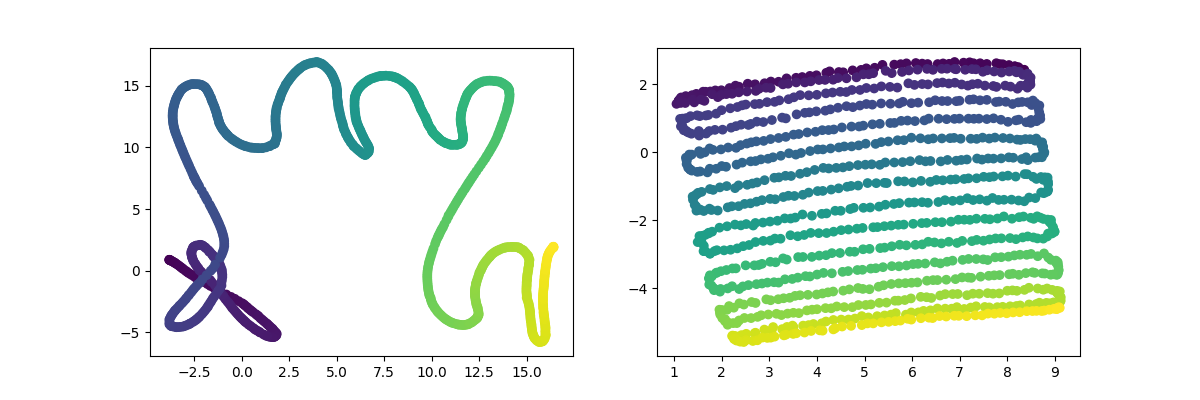

In [149]:
fig=plt.figure(figsize=(12,4))
ax=fig.subplots(1,2)
ax[0].scatter(emb1[:,0],emb1[:,1],c=x)
ax[1].scatter(emb2[:,0],emb2[:,1],c=x)
plt.show()

In [22]:
# similar effects exist in most graph/neighbourhood based embedding methods